In [1]:
%pylab inline
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from pandas import concat, DataFrame
import seaborn as sns
plt.style.use('ggplot')
import logging
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed, MaxPooling1D, Flatten, Conv1D, Input
from tensorflow.keras.utils import plot_model
from ClarkeErrorGrid import clarke_error_grid
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
import random
import tensorflow.keras.backend as keras_backend
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

Populating the interactive namespace from numpy and matplotlib


# Project: Blood glucose prediction with neural network
# Author: Martin Nanchev

The idea behind the project is to explore the opportunity to use neuronal network to predict blood glucose, based on historical values. Machine learning models were tested and developed and have acceptable accuracy - https://github.com/mnanchev/blood_glucose_ml_modells
This paper analyze the same topic, but with the help of Deep Learning using Tensorflow

## 1 Read and clean data Exploratory data analysis

The dataset would be cleaned and visualized. After that it will be downsampled, scaled between 0 and 1 using MinMaxScaler. The last step is to determine the number of lags and shift the dataset.

In [2]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1,
                          write_graph=True, write_images=True)
blood_glucose_dataset = pd.read_excel("./blood_sugar_data_complete.xls")
blood_glucose_dataset.drop(["BASAL_TS","BOLUS_TS"],axis=1,inplace=True)

In [3]:
blood_glucose_dataset.shape

(4613, 2)

In [4]:
blood_glucose_dataset

,DATETIME,BLOOD_GLUCOSE
0,2020-10-11 16:00:00,3.6
1,2020-10-11 16:05:00,3.7
2,2020-10-11 16:10:00,3.7
3,2020-10-11 16:15:00,3.7
4,2020-10-11 16:20:00,4.1
...,...,...
4608,2020-10-25 18:28:00,6.9
4609,2020-10-25 18:28:00,6.9
4610,2020-10-25 18:29:00,6.9
4611,2020-10-25 18:30:00,6.9


In [5]:
def plot_line_chart(x, y = pd.Series([]), figsize = (10,5), title = "", xlabel = "", ylabel= ""):
    if not(x.empty) and not(y.empty):
        plt.figure(figsize=figsize)
        plt.fill_between( x, y, color="skyblue", alpha=0.3)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.plot(x, y, color="skyblue")
    elif not(x.empty):
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.plot(x, color="skyblue")
       

def downsample(dataset, index, column,  period = "30min"):
    dataset.set_index(index, inplace=True)
    time_series = dataset[column].resample(period).mean()
    return time_series

def min_max_scaling(dataset, min, max, column, index):
    dataset = dataset.reset_index()
    dataset[column]=tf.math.divide(tf.math.subtract(blood_glucose_time_series,np.float64(min)),  tf.math.subtract(np.float64(max),np.float64(min)))
    dataset.set_index(index, inplace=True)
    return dataset

def inverse_min_max_scaling(dataset, min, max):
	inverse_min_max_scaler = np.add(np.multiply((np.subtract(max, min)),dataset),min)
	return inverse_min_max_scaler

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def train_test_split(dataset, size=0.67):
	train_size = int(len(dataset) * size)
	test_size = len(dataset) - train_size
	#dataset = dataset.sample(frac=1).reset_index(drop=True)
	train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
	return (train, test)

def scheduler(epoch, lr):
	if epoch < 10:
		return lr
	else:
		return lr * tf.math.exp(-0.1)

def create_model(architecture, trainX, trainY, testX, testY, loss='mean_squared_error', optimizer='adam',model_name="",patience=0):
	model = tf.keras.Sequential(architecture)
	model.compile(loss=loss, optimizer=optimizer)
	print("Before training: ",model.trainable_weights[1])
	print("Before training: ",model.trainable_weights[0])
	es = EarlyStopping(monitor='loss', mode='min', patience=patience, restore_best_weights=True)
	history = model.fit(trainX, trainY, validation_data=(testX, testY) ,epochs=50, batch_size=1,callbacks=[es, tensorboard],verbose=2)
	model.summary()
	model.save(model_name)
	
	if not ("encoder" in model_name):
		trainPredict = model.predict(trainX)
		testPredict = model.predict(testX)
		trainPredict = inverse_min_max_scaling(trainPredict, 1.0, 36)
		trainY_inverse = inverse_min_max_scaling(trainY, 1.0, 36)
		testPredict = inverse_min_max_scaling(testPredict, 1.0, 36)
		testY_inverse  = inverse_min_max_scaling(testY, 1.0, 36)
		# calculate root mean squared error
		trainScore = math.sqrt(mean_squared_error(trainY_inverse, trainPredict))
		print('Train Score: %.2f RMSE' % (trainScore))
		testScore = math.sqrt(mean_squared_error(testY_inverse, testPredict))
		print('Test Score: %.2f RMSE' % (testScore))
		plt.xlabel("points in time")
		plt.ylabel("mmol/dL")
		plt.plot(testPredict, label="prediction")
		plt.plot(np.array(testY_inverse), label="test")
		plt.legend()
		plt.show()
		r2 = r2_score(np.array(testY_inverse), testPredict)
		print("R squared for the test score: ",r2)
		plt.plot(history.history['loss'], label="loss")
		plt.plot(history.history['val_loss'], label="validation_loss")
		plt.legend()
		plt.title('model loss')
		plt.ylabel('loss')
		plt.xlabel('epoch')
		plt.show()
		plot, zone = clarke_error_grid(testPredict*18, np.array(testY_inverse*18),model_name) 
		print("After training: ",model.trainable_weights[1])
		print("After training: ",model.trainable_weights[0])
		plt.show()
	else:
		testPredict = model.predict(testX)
		testY_inverse  = inverse_min_max_scaling(testY, 1.0, 36)
		mean_value = [(values[0] + values[1])/2.0 for values in testPredict]
		mean_value = inverse_min_max_scaling(mean_value, 1.0, 36)

		testScore = math.sqrt(mean_squared_error(testY_inverse, mean_value))
		print('Test Score: %.2f RMSE' % (testScore))
		plt.xlabel("points in time")
		plt.ylabel("mmol/dL")
		plt.plot(mean_value, label="prediction")
		plt.plot(np.array(testY_inverse), label="test")
		plt.legend()
		plt.show()
		r2 = r2_score(np.array(testY_inverse), mean_value)
		print("R squared for the test score: ",r2)
		plt.plot(history.history['loss'],label="loss")
		plt.plot(history.history['val_loss'],label="validation_loss")
		plt.title('model loss')
		plt.legend()
		plt.ylabel('loss')
		plt.xlabel('epoch')
		plt.show()
		plot, zone = clarke_error_grid(mean_value*18, np.array(testY_inverse*18),model_name)
		print("After training: ",model.trainable_weights[1])
		print("After training: ",model.trainable_weights[0])
		plt.show()
	return model


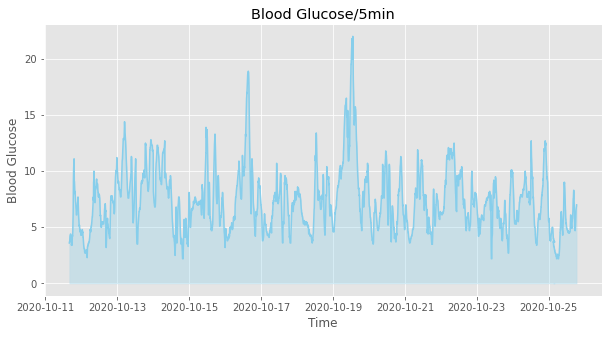

In [6]:
plot_line_chart(blood_glucose_dataset.DATETIME, blood_glucose_dataset.BLOOD_GLUCOSE, title = "Blood Glucose/5min", xlabel = "Time", ylabel = "Blood Glucose")

### 1.1 Nyquist Theorem

To present a signal with frequency of B, a samples rate of 2B/s will be required or:
If a function x(t) contains no frequencies higher than B hertz, it is completely determined by giving its ordinates at a series of points spaced $$ \frac{1}{2B} $$ 
seconds apart.

In blood glucose, we will need 6 samples to downsample to 30 minutes


In [7]:
blood_glucose_time_series = downsample(dataset=blood_glucose_dataset,column="BLOOD_GLUCOSE", index="DATETIME")

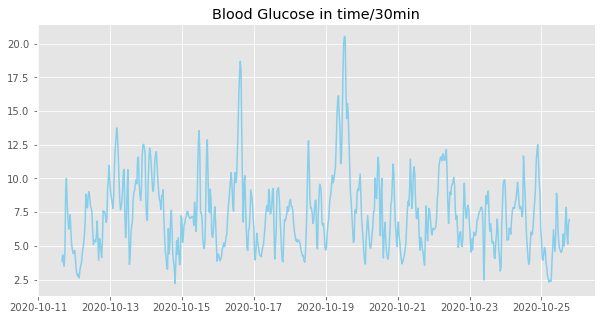

In [8]:
plot_line_chart(blood_glucose_time_series, title = "Blood Glucose in time/30min")

### 1.2 Scaling the data after downsampling

Neural networks require the features to be scaled for best performance. A min max scaler will be used for this purpose

$$ x'={\frac  {x-{\text{min}}(x)}{{\text{max}}(x)-{\text{min}}(x)}} $$

In [9]:
blood_glucose_time_series_scaled = min_max_scaling(blood_glucose_time_series,1.0,36.0,"BLOOD_GLUCOSE","DATETIME")

### 1.3 Transforming from time series to supervised learning problem 
To transform timeseries to supervised learning problem the features will be shifted by a lag of 5. The last column will be the label and all others will be the features matrix. This means, that we will lose 5 elements for which we don't have historical values. 

In [10]:
blood_glucose_time_series_scaled_to_supervised = series_to_supervised(blood_glucose_time_series_scaled,5)

### 1.4 Split the dataset in testing and training

In [11]:
train, test = train_test_split(blood_glucose_time_series_scaled_to_supervised , size=0.8)

### 1.5 Planing of the model creation and defining labels and features

1. Vanilla LSTM
2. Stacked LSTM
3. Bidirectional LSTM
4. Multi-Step LSTM using Encoder-Decoder Model
5. CNN LSTM


#### 1.5.1 Long short-term memory is an artificial recurrent neural network, which acts like state machine and uses features and state as input:

<img src="The_LSTM_Cell.png" width="200" height="200"/>

The image show the LSTM neuron cosist of:

- Forget gates - which decides what to keep and what to throw away at time t-1
- Input gate - accepts input values at time t-1 and updates the state
- Output gate - determines the output based on the state and input.

 \begin{aligned}f_{t}&=\sigma _{g}(W_{f}x_{t}+U_{f}h_{t-1}+b_{f})\\i_{t}&=\sigma _{g}(W_{i}x_{t}+U_{i}h_{t-1}+b_{i})\\o_{t}&=\sigma _{g}(W_{o}x_{t}+U_{o}h_{t-1}+b_{o})\\{\tilde {c}}_{t}&=\sigma _{c}(W_{c}x_{t}+U_{c}h_{t-1}+b_{c})\\c_{t}&=f_{t}\circ c_{t-1}+i_{t}\circ {\tilde {c}}_{t}\\h_{t}&=o_{t}\circ \sigma _{h}(c_{t})\end{aligned}

 #### 1.5.2 Convolutional neural network 

Convolutional neural network applies filters using operation called convolution, which extract features from images, scene:

<img src="CNN.png" width="600" height="200"/>

The convolution is defined by:

$$ (f*g)(t):=\int _{-\infty }^{\infty }f(\tau )g(t-\tau )\,d\tau $$



In [12]:

trainY = train["var1(t)"]
trainX = train.drop(["var1(t)"], axis=1)
trainX_initial = trainX
trainX = np.reshape(trainX.to_numpy(), (trainX.to_numpy().shape[0], 1, trainX.to_numpy().shape[1]))


testY = test["var1(t)"]
testX = test.drop(["var1(t)"], axis=1)
testX_initial = testX
testX = np.reshape(testX.to_numpy(), (testX.to_numpy().shape[0], 1, testX.to_numpy().shape[1]))

### 1.6 Feature importance

#### 1.6.1 Feature importance

A test with randomly initialized weights to check if the weights are changing

Recurrent kernel 0 before training:  <tf.Variable 'dense/kernel:0' shape=(5, 1) dtype=float32, numpy=
array([[ 0.00469565],
       [-0.4712324 ],
       [ 0.16327739],
       [ 0.10994554],
       [-0.5534835 ]], dtype=float32)>
Output kernel 1 before training:  <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>
Epoch 1/20
538/538 - 1s - loss: 0.0432 - val_loss: 0.0277
Epoch 2/20
538/538 - 1s - loss: 0.0432 - val_loss: 0.0277
Epoch 3/20
538/538 - 1s - loss: 0.0432 - val_loss: 0.0277
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 1)              6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: test/assets
Kernel after training:  <tf.Variable 'dense/kernel:0' shape=(5, 1) dtype=float32, nu

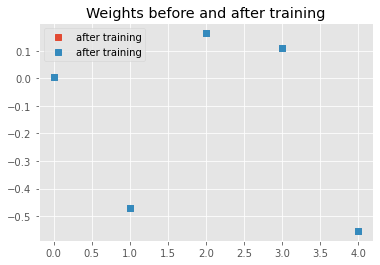

In [13]:
one_neuron_model_architecture = [
  layers.Dense(1,input_shape=(1, 5
  ),activation="relu"),
]

model = tf.keras.Sequential(one_neuron_model_architecture)
model.compile(loss="mean_squared_error", optimizer="adam")
print("Recurrent kernel 0 before training: ",model.trainable_weights[0])
print("Output kernel 1 before training: ",model.trainable_weights[1])
plt.title("Weights before and after training")
plt.plot(model.trainable_weights[0].numpy(),'s',label="after training")
es = EarlyStopping(monitor='loss', mode='min', patience=0, restore_best_weights=True)
history = model.fit(trainX, trainY, validation_data=(testX, testY) ,epochs=20, batch_size=1,callbacks=[es,tensorboard],verbose=2)
model.summary()
model.save("test")
print("Kernel after training: ",model.trainable_weights[0])
print("Output of lstm after training: ",model.trainable_weights[1])
array_weights = model.trainable_weights[0]
plt.plot(array_weights.numpy(),'s',label="after training")
plt.legend()
plt.show()


#### 1.6.2 Desicion tree and Random Forest Regression Feature Importance

Feature: 0, Score: 0.01337
Feature: 1, Score: 0.03739
Feature: 2, Score: 0.02777
Feature: 3, Score: 0.05738
Feature: 4, Score: 0.86410


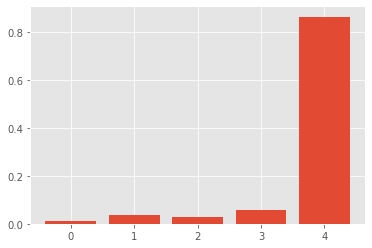

In [14]:
model = DecisionTreeRegressor()
model.fit(trainX_initial, trainY)
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: 0, Score: 0.02185
Feature: 1, Score: 0.02799
Feature: 2, Score: 0.02812
Feature: 3, Score: 0.05295
Feature: 4, Score: 0.86909


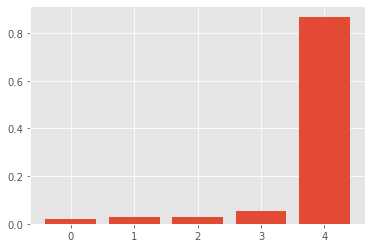

In [15]:
model = RandomForestRegressor()
model.fit(trainX_initial, trainY)
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

           var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)   var1(t)
var1(t-5)   1.000000   0.885242   0.703342   0.573189   0.488389  0.409422
var1(t-4)   0.885242   1.000000   0.884567   0.701611   0.571073  0.486641
var1(t-3)   0.703342   0.884567   1.000000   0.884061   0.700175  0.569508
var1(t-2)   0.573189   0.701611   0.884061   1.000000   0.883204  0.698844
var1(t-1)   0.488389   0.571073   0.700175   0.883204   1.000000  0.882820
var1(t)     0.409422   0.486641   0.569508   0.698844   0.882820  1.000000


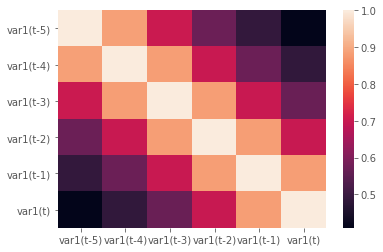

In [16]:

result = train.corr(method='spearman')
sns.heatmap(result)
print(result)

#### 1.6.3 Results

Based on the results var1(t-5) will be eliminated:


In [17]:
trainX = train.drop(["var1(t)","var1(t-5)"], axis=1)
trainX_initial = trainX
trainX = np.reshape(trainX.to_numpy(), (trainX.to_numpy().shape[0], 1, trainX.to_numpy().shape[1]))

testX = test.drop(["var1(t)","var1(t-5)"], axis=1)
testX_initial = testX
testX = np.reshape(testX.to_numpy(), (testX.to_numpy().shape[0], 1, testX.to_numpy().shape[1]))

In [18]:
df = train.drop(["var1(t-5)"], axis=1)
df.to_csv('out.csv',index=False)

## 2 Building Deep learning models

### 2.1 Vanilla LSTM

Before training:  <tf.Variable 'lstm/lstm_cell/recurrent_kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[ 0.5486454 ,  0.27652338,  0.20194864, -0.7627188 ]],
      dtype=float32)>
Before training:  <tf.Variable 'lstm/lstm_cell/kernel:0' shape=(4, 4) dtype=float32, numpy=
array([[ 0.79582816, -0.3537447 ,  0.5240627 ,  0.22404152],
       [ 0.5717016 , -0.42939687,  0.2688517 , -0.14795244],
       [-0.10755509,  0.5022767 ,  0.3473031 ,  0.38791305],
       [-0.18167561, -0.77773935,  0.14631611, -0.3105622 ]],
      dtype=float32)>
Epoch 1/50
538/538 - 3s - loss: 0.0227 - val_loss: 0.0054
Epoch 2/50
538/538 - 1s - loss: 0.0082 - val_loss: 0.0055
Epoch 3/50
538/538 - 1s - loss: 0.0072 - val_loss: 0.0051
Epoch 4/50
538/538 - 1s - loss: 0.0062 - val_loss: 0.0054
Epoch 5/50
538/538 - 1s - loss: 0.0050 - val_loss: 0.0035
Epoch 6/50
538/538 - 1s - loss: 0.0039 - val_loss: 0.0028
Epoch 7/50
538/538 - 1s - loss: 0.0031 - val_loss: 0.0020
Epoch 8/50
538/538 - 1s - loss: 0.0027 - val_loss

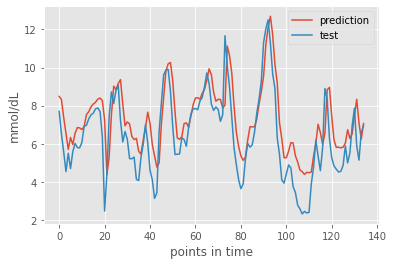

R squared for the test score:  0.5415932482676715


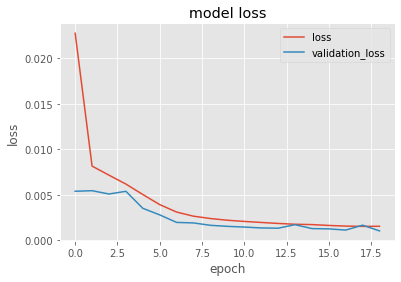

After training:  <tf.Variable 'lstm/lstm_cell/recurrent_kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[ 0.5486454 ,  0.27652338,  0.20194864, -0.7627188 ]],
      dtype=float32)>
After training:  <tf.Variable 'lstm/lstm_cell/kernel:0' shape=(4, 4) dtype=float32, numpy=
array([[ 1.1403066 , -0.3537447 ,  0.20028912,  0.5181886 ],
       [ 0.8732392 , -0.42939687,  0.01314814,  0.10626032],
       [ 0.36665836,  0.5022767 , -0.10813364,  0.810235  ],
       [ 0.7713823 , -0.77773935, -0.94909835,  0.5643399 ]],
      dtype=float32)>


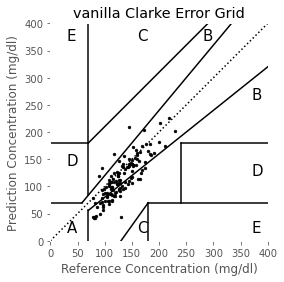

In [19]:
vanilla_lstm_architecture = [
  layers.LSTM(1,input_shape=(1, 4
  )),
  layers.Dense(1)
]

vanilla_lstm_model = create_model(vanilla_lstm_architecture, trainX, trainY, testX, testY, model_name="vanilla")


### 2.1.1 Results of vanilla model 
The validation data is easier than the training data, which is the reason for the higher training loss. As a conclusion a more data will be collected to improve the model.

### 2.2 Stacked LSTM

The LSMT layer with two neurons will return a full sequence to the next LSTM layer.
Transfer learning is the process of tranfering layers of trained neural network to new architecture to reduce the learning time and improve the overall results. We will transfer the already trained layer from the vanilla modell to the Stacked LSTM and see if the result improves in comparison with the Stacked LSTM, trained from the beginning.

#### 2.2.1 Stacked LSTM with randomly initialized weights

In [20]:
transfer_learning_layers = None
for i, layer in enumerate(vanilla_lstm_model.layers):
  layer.trainable = False
  if "lstm" in layer.name:
      print("Initial return sequence of vanilla lstm: ",layer.return_sequences )
      layer.return_sequences = True
      transfer_learning_layers = layer
  print(i, layer.name)

print("Return sequence after augmentation: ",vanilla_lstm_model.layers[0].return_sequences )

Initial return sequence of vanilla lstm:  False
0 lstm
1 dense_1
Return sequence after augmentation:  True


Before training:  <tf.Variable 'lstm_1/lstm_cell_1/recurrent_kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[ 0.61917603,  0.6110917 , -0.18137611,  0.4585746 ]],
      dtype=float32)>
Before training:  <tf.Variable 'lstm_1/lstm_cell_1/kernel:0' shape=(4, 4) dtype=float32, numpy=
array([[ 0.5175219 ,  0.8103748 ,  0.4387526 , -0.4249787 ],
       [-0.6946554 ,  0.6054153 , -0.69440436, -0.4671507 ],
       [-0.20578235, -0.77932817, -0.19603604,  0.47798783],
       [ 0.483571  ,  0.21454912, -0.5580293 ,  0.5057308 ]],
      dtype=float32)>
Epoch 1/50
538/538 - 5s - loss: 0.0106 - val_loss: 0.0048
Epoch 2/50
538/538 - 1s - loss: 0.0061 - val_loss: 0.0040
Epoch 3/50
538/538 - 1s - loss: 0.0052 - val_loss: 0.0034
Epoch 4/50
538/538 - 1s - loss: 0.0040 - val_loss: 0.0024
Epoch 5/50
538/538 - 1s - loss: 0.0031 - val_loss: 0.0020
Epoch 6/50
538/538 - 1s - loss: 0.0025 - val_loss: 0.0018
Epoch 7/50
538/538 - 1s - loss: 0.0023 - val_loss: 0.0017
Epoch 8/50
538/538 - 1s - loss: 0.0023 - 

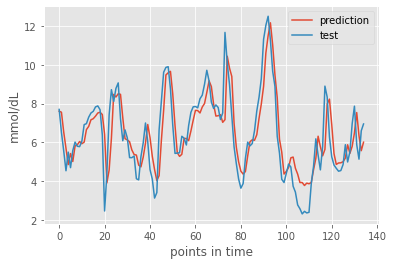

R squared for the test score:  0.6955660990975572


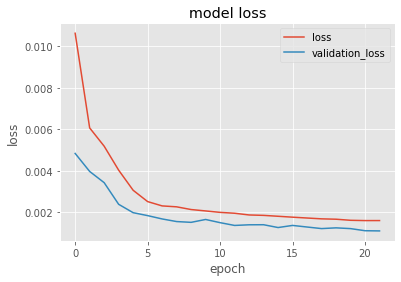

After training:  <tf.Variable 'lstm_1/lstm_cell_1/recurrent_kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[ 0.61917603,  0.6110917 , -0.18137611,  0.4585746 ]],
      dtype=float32)>
After training:  <tf.Variable 'lstm_1/lstm_cell_1/kernel:0' shape=(4, 4) dtype=float32, numpy=
array([[ 1.1426893 ,  0.8103748 ,  0.45649254,  0.24561448],
       [-0.20080051,  0.6054153 , -0.41911823,  0.08542813],
       [ 0.4814834 , -0.77932817, -0.2249201 ,  1.2182895 ],
       [ 1.7865626 ,  0.21454912, -1.7816882 ,  1.8266855 ]],
      dtype=float32)>


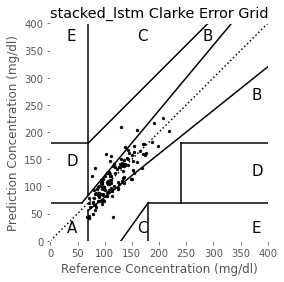

In [21]:

stacked_lstm_architecture = [
  layers.LSTM(1,input_shape=(1, 4
  ),return_sequences=True),
  layers.LSTM(1,input_shape=(1, 4
  )),
  layers.Dense(1)
]

stacked_lstm_model = create_model(stacked_lstm_architecture, trainX, trainY, testX, testY, model_name="stacked_lstm")

#### 2.2.2 Stacked LSTM using input layer from the vanilla model

Before training:  <tf.Variable 'lstm_3/lstm_cell_3/recurrent_kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[-0.02489841,  0.57940805, -0.7738201 ,  0.25469345]],
      dtype=float32)>
Before training:  <tf.Variable 'lstm_3/lstm_cell_3/kernel:0' shape=(1, 4) dtype=float32, numpy=array([[ 0.6897639,  0.3337624,  0.0865705, -0.5178432]], dtype=float32)>
Epoch 1/50
538/538 - 5s - loss: 0.0098 - val_loss: 0.0045
Epoch 2/50
538/538 - 1s - loss: 0.0058 - val_loss: 0.0040
Epoch 3/50
538/538 - 1s - loss: 0.0053 - val_loss: 0.0035
Epoch 4/50
538/538 - 1s - loss: 0.0047 - val_loss: 0.0032
Epoch 5/50
538/538 - 1s - loss: 0.0042 - val_loss: 0.0032
Epoch 6/50
538/538 - 1s - loss: 0.0036 - val_loss: 0.0027
Epoch 7/50
538/538 - 1s - loss: 0.0030 - val_loss: 0.0019
Epoch 8/50
538/538 - 1s - loss: 0.0025 - val_loss: 0.0019
Epoch 9/50
538/538 - 1s - loss: 0.0021 - val_loss: 0.0018
Epoch 10/50
538/538 - 1s - loss: 0.0018 - val_loss: 0.0012
Epoch 11/50
538/538 - 1s - loss: 0.0017 - val_loss: 0.0012
E

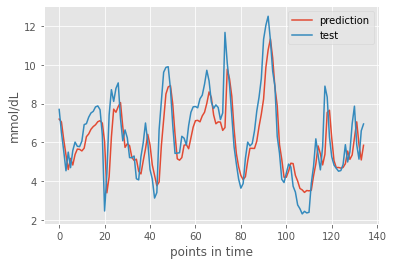

R squared for the test score:  0.675050168489649


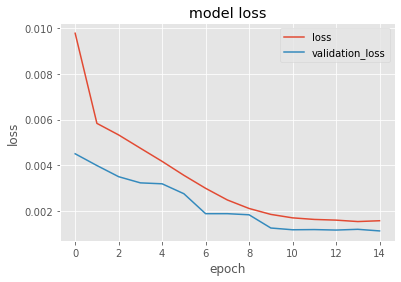

After training:  <tf.Variable 'lstm_3/lstm_cell_3/recurrent_kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[-0.02489841,  0.57940805, -0.7738201 ,  0.25469345]],
      dtype=float32)>
After training:  <tf.Variable 'lstm_3/lstm_cell_3/kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[-0.65716684,  0.3337624 ,  1.2968463 , -1.8867908 ]],
      dtype=float32)>


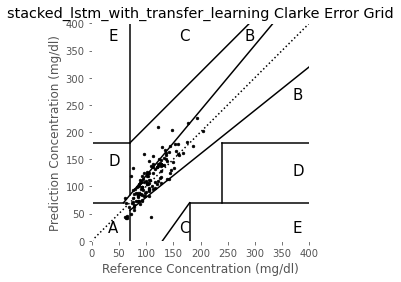

In [22]:
stacked_lstm_architecture_with_transfer_learning = [
  transfer_learning_layers,
  layers.LSTM(1,input_shape=(1, 4
  )),
  layers.Dense(1)
]

stacked_lstm_model = create_model(stacked_lstm_architecture_with_transfer_learning, trainX, trainY, testX, testY, model_name="stacked_lstm_with_transfer_learning")

### 2.2.3 Results of stacked lstm model 
The validation data is easier than the training data, which is the reason for the higher training loss. As a conclusion a more data will be collected to improve the model.

### 2.3 Bidirectional LSTM

Before training:  <tf.Variable 'bidirectional/forward_lstm_4/lstm_cell_5/recurrent_kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[-0.47454596,  0.1787665 , -0.49686918, -0.70425105]],
      dtype=float32)>
Before training:  <tf.Variable 'bidirectional/forward_lstm_4/lstm_cell_5/kernel:0' shape=(4, 4) dtype=float32, numpy=
array([[ 0.36397308, -0.5315988 ,  0.10163021, -0.05717832],
       [-0.3283522 , -0.75268483, -0.03909218,  0.20288366],
       [ 0.3074264 , -0.7861121 , -0.07671964,  0.28076035],
       [ 0.61384004, -0.3102401 ,  0.7930972 , -0.49295986]],
      dtype=float32)>
Epoch 1/50
538/538 - 4s - loss: 0.0050 - val_loss: 0.0022
Epoch 2/50
538/538 - 1s - loss: 0.0022 - val_loss: 0.0013
Epoch 3/50
538/538 - 1s - loss: 0.0018 - val_loss: 0.0013
Epoch 4/50
538/538 - 1s - loss: 0.0015 - val_loss: 0.0010
Epoch 5/50
538/538 - 1s - loss: 0.0014 - val_loss: 9.7121e-04
Epoch 6/50
538/538 - 1s - loss: 0.0013 - val_loss: 8.9953e-04
Epoch 7/50
538/538 - 1s - loss: 0.0012 - val_lo

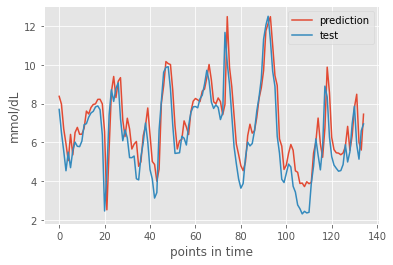

R squared for the test score:  0.692642885192653


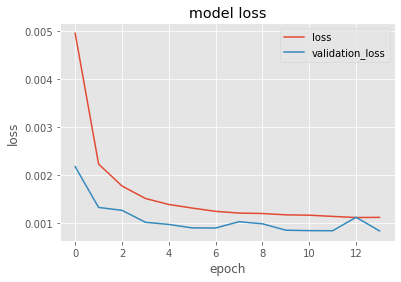

After training:  <tf.Variable 'bidirectional/forward_lstm_4/lstm_cell_5/recurrent_kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[-0.47454596,  0.1787665 , -0.49686918, -0.70425105]],
      dtype=float32)>
After training:  <tf.Variable 'bidirectional/forward_lstm_4/lstm_cell_5/kernel:0' shape=(4, 4) dtype=float32, numpy=
array([[ 0.6667916 , -0.5315988 ,  0.28186992,  0.26279852],
       [-0.10718652, -0.75268483,  0.04215594,  0.4508181 ],
       [ 0.49801505, -0.7861121 , -0.06488279,  0.5095749 ],
       [ 1.0621622 , -0.3102401 ,  1.1482978 , -0.03608023]],
      dtype=float32)>


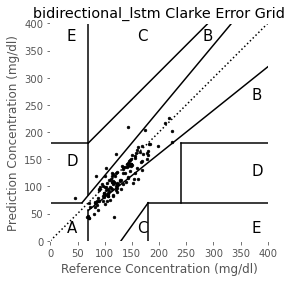

In [23]:
bidirectional_lstm_architecture = [
  layers.Bidirectional(layers.LSTM(1), input_shape=(1, 4
  )),
  layers.Dense(1)
]

bidirectional_lstm_model = create_model(bidirectional_lstm_architecture, trainX, trainY, testX, testY, model_name="bidirectional_lstm")

#### 2.3.1 Bidirectional LSTM with transfer learning

Before training:  <tf.Variable 'bidirectional/forward_lstm_4/lstm_cell_5/recurrent_kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[-0.47454596,  0.1787665 , -0.49686918, -0.70425105]],
      dtype=float32)>
Before training:  <tf.Variable 'bidirectional/forward_lstm_4/lstm_cell_5/kernel:0' shape=(4, 4) dtype=float32, numpy=
array([[ 0.6667916 , -0.5315988 ,  0.28186992,  0.26279852],
       [-0.10718652, -0.75268483,  0.04215594,  0.4508181 ],
       [ 0.49801505, -0.7861121 , -0.06488279,  0.5095749 ],
       [ 1.0621622 , -0.3102401 ,  1.1482978 , -0.03608023]],
      dtype=float32)>
Epoch 1/50
538/538 - 3s - loss: 0.0011 - val_loss: 8.2759e-04
Epoch 2/50
538/538 - 1s - loss: 0.0011 - val_loss: 8.3551e-04
Epoch 3/50
538/538 - 1s - loss: 0.0011 - val_loss: 8.5512e-04
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 2)                 48      

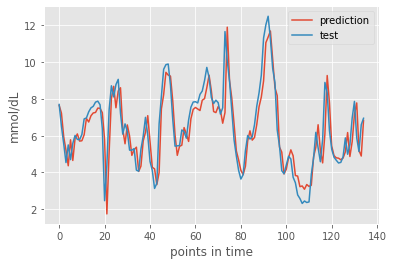

R squared for the test score:  0.7709385471013921


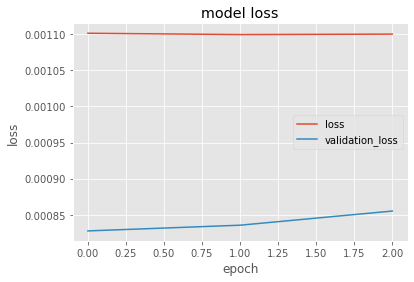

After training:  <tf.Variable 'bidirectional/forward_lstm_4/lstm_cell_5/recurrent_kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[-0.47454596,  0.1787665 , -0.49686918, -0.70425105]],
      dtype=float32)>
After training:  <tf.Variable 'bidirectional/forward_lstm_4/lstm_cell_5/kernel:0' shape=(4, 4) dtype=float32, numpy=
array([[ 0.68502545, -0.5315988 ,  0.30098328,  0.2787855 ],
       [-0.10673089, -0.75268483,  0.04312406,  0.4505333 ],
       [ 0.47646806, -0.7861121 , -0.09712062,  0.4913418 ],
       [ 1.07021   , -0.3102401 ,  1.1477189 , -0.0260465 ]],
      dtype=float32)>


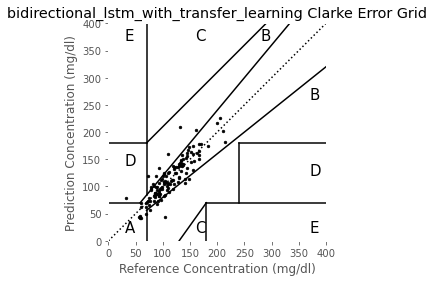

In [24]:
bidirectional_lstm_architecture_with_transfer_learning = [
  layers.Bidirectional(transfer_learning_layers,input_shape=(1, 4
  )),
  layers.Dense(1)
]

bidirectional_lstm_model_with_transfer_learning = create_model(bidirectional_lstm_architecture, trainX, trainY, testX, testY, model_name="bidirectional_lstm_with_transfer_learning")

### 2.3.2 Results of bidirectional lstm model 
The validation data is easier than the training data, which is the reason for the higher training loss. As a conclusion a more data will be collected to improve the model.

### 2.4 Encoder-Decoder model

Before training:  <tf.Variable 'lstm_5/lstm_cell_9/recurrent_kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[-0.19717693,  0.2899479 ,  0.03344059, -0.9359131 ]],
      dtype=float32)>
Before training:  <tf.Variable 'lstm_5/lstm_cell_9/kernel:0' shape=(4, 4) dtype=float32, numpy=
array([[ 0.21406049,  0.14974004, -0.52066505,  0.3547662 ],
       [ 0.80055064, -0.37915143,  0.12502962,  0.62523395],
       [-0.81081355,  0.12923533,  0.12657923,  0.41607517],
       [ 0.09058684,  0.6362533 , -0.6662193 ,  0.13312823]],
      dtype=float32)>
Epoch 1/50
538/538 - 5s - loss: 0.0080 - val_loss: 0.0034
Epoch 2/50
538/538 - 1s - loss: 0.0048 - val_loss: 0.0031
Epoch 3/50
538/538 - 1s - loss: 0.0039 - val_loss: 0.0025
Epoch 4/50
538/538 - 1s - loss: 0.0033 - val_loss: 0.0020
Epoch 5/50
538/538 - 1s - loss: 0.0028 - val_loss: 0.0023
Epoch 6/50
538/538 - 1s - loss: 0.0025 - val_loss: 0.0021
Epoch 7/50
538/538 - 1s - loss: 0.0024 - val_loss: 0.0017
Epoch 8/50
538/538 - 1s - loss: 0.0022 - 

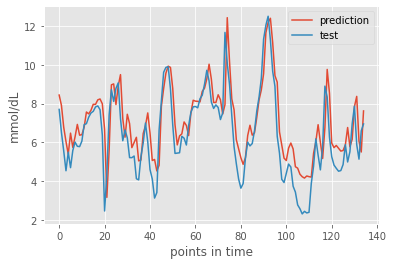

R squared for the test score:  0.6587710656863027


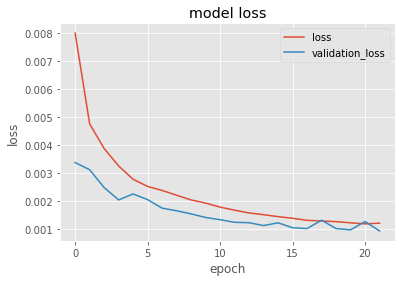

After training:  <tf.Variable 'lstm_5/lstm_cell_9/recurrent_kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[-0.19717693,  0.2899479 ,  0.03344059, -0.9359131 ]],
      dtype=float32)>
After training:  <tf.Variable 'lstm_5/lstm_cell_9/kernel:0' shape=(4, 4) dtype=float32, numpy=
array([[ 0.45659128,  0.14974004, -0.18916678,  0.7092001 ],
       [ 1.0850489 , -0.37915143,  0.35385117,  1.0250764 ],
       [-0.37043363,  0.12923533,  0.14756724,  0.9714915 ],
       [ 0.9436613 ,  0.6362533 , -1.3943753 ,  1.1136093 ]],
      dtype=float32)>


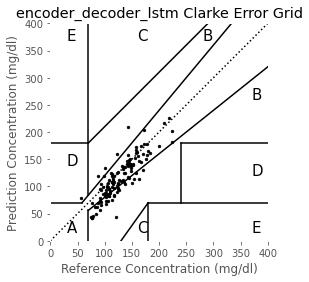

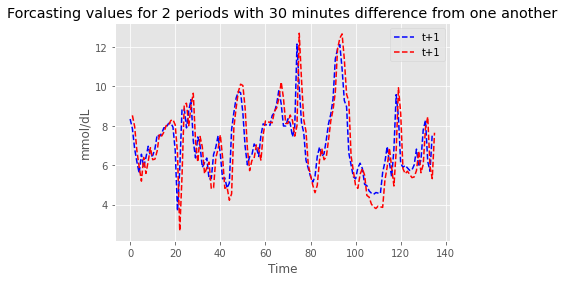

In [25]:
encoder_decoder_lstm_architecture = [
  layers.LSTM(1,input_shape=(1, 4
  )),
  layers.RepeatVector(2),
  layers.LSTM(1,input_shape=(1, 4
  ),return_sequences=True),
  layers.TimeDistributed(layers.Dense(1))
]

encoder_decoder_lstm_model = create_model(encoder_decoder_lstm_architecture, trainX, trainY, testX, testY, model_name="encoder_decoder_lstm")
multiple_output_values = encoder_decoder_lstm_model.predict(testX)
initial_forecast = inverse_min_max_scaling([values[0] for values in multiple_output_values],1.0,36.0)
next_forecast = inverse_min_max_scaling([values[1] for values in multiple_output_values],1.0,36.0)
initial_forcast_index = [i for i in range(len(initial_forecast))]
next_forcast_index = [i+1 for i in range(len(initial_forecast))]
initial = plt.plot(initial_forcast_index,initial_forecast,'b--',label="t+1")
next = plt.plot(next_forcast_index,next_forecast,'b--',label="t+1",c="r")
plt.title('Forcasting values for 2 periods with 30 minutes difference from one another')
plt.xlabel('Time')
plt.ylabel('mmol/dL')

plt.legend()
plt.show()

### 2.4.1 Results of stacked lstm model 
The validation data is easier than the training data, which is the reason for the higher training loss. As a conclusion a more data will be collected to improve the model.

### 2.5 CNN LSTM

Before training:  <tf.Variable 'time_distributed_1/bias:0' shape=(5,) dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>
Before training:  <tf.Variable 'time_distributed_1/kernel:0' shape=(3, 1, 5) dtype=float32, numpy=
array([[[ 0.5558691 , -0.21316722,  0.25089806,  0.27212054,
          0.23228967]],

       [[-0.24842653, -0.4674209 , -0.4086913 ,  0.07977939,
          0.5249672 ]],

       [[-0.06570882,  0.5468544 , -0.17261302,  0.01412618,
         -0.02125317]]], dtype=float32)>
Epoch 1/50
538/538 - 4s - loss: 0.0103 - val_loss: 0.0037
Epoch 2/50
538/538 - 1s - loss: 0.0048 - val_loss: 0.0038
Epoch 3/50
538/538 - 2s - loss: 0.0036 - val_loss: 0.0027
Epoch 4/50
538/538 - 1s - loss: 0.0031 - val_loss: 0.0023
Epoch 5/50
538/538 - 2s - loss: 0.0029 - val_loss: 0.0021
Epoch 6/50
538/538 - 1s - loss: 0.0026 - val_loss: 0.0022
Epoch 7/50
538/538 - 1s - loss: 0.0025 - val_loss: 0.0019
Epoch 8/50
538/538 - 1s - loss: 0.0024 - val_loss: 0.0017
Epoch 9/50
538/538 - 1s - lo

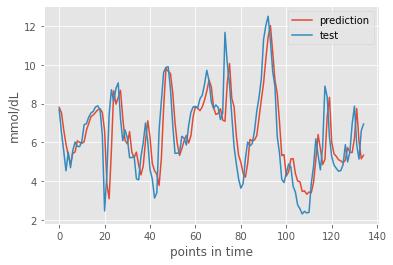

R squared for the test score:  0.6323064556363753


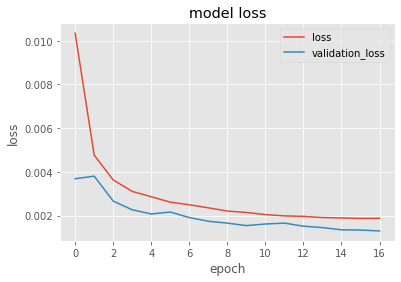

After training:  <tf.Variable 'time_distributed_1/bias:0' shape=(5,) dtype=float32, numpy=
array([-0.05110082,  0.06331745,  0.05699386, -0.05587873, -0.02600772],
      dtype=float32)>
After training:  <tf.Variable 'time_distributed_1/kernel:0' shape=(3, 1, 5) dtype=float32, numpy=
array([[[ 0.43917882, -0.31341586,  0.38870177,  0.2799046 ,
          0.15971185]],

       [[-0.4219774 , -0.72607243, -0.19585225,  0.14686279,
          0.4373952 ]],

       [[-0.6950848 ,  0.18684882,  0.44355938,  0.5559699 ,
         -0.57540476]]], dtype=float32)>


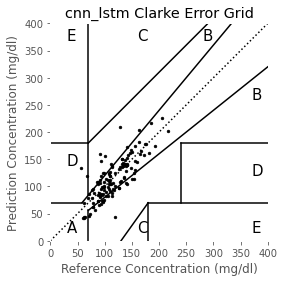

In [26]:
number_features = 1
number_sequences = 1
number_steps = 4
trainX_cnn = array(trainX_initial).reshape((trainX_initial.shape[0], number_sequences, number_steps, number_features))
testX_cnn = array(testX_initial).reshape((testX_initial.shape[0], number_sequences, number_steps, number_features))

cnn_lstm_architecture = [
  layers.TimeDistributed(layers.Conv1D(filters=5, kernel_size=3), input_shape=(None, number_steps, number_features)),
  layers.TimeDistributed(layers.MaxPooling1D(pool_size=2,padding='same')),
  layers.TimeDistributed(layers.Flatten()),
  layers.LSTM(1),
  layers.Dense(1)
]

cnn_lstm_model = create_model(cnn_lstm_architecture, trainX_cnn, trainY, testX_cnn, testY, model_name="cnn_lstm")


### 2.5.1 Results of cnn model 
The validation data is easier than the training data, which is the reason for the higher training loss. As a conclusion a more data will be collected to improve the model.

### 2.5 SUMMARY

1. More data will be collected to improve the developed models
2. CNN extracts the right feature and is showing promissing performance witg RMSE of 1.10 for the training and 1.02 for the validation data. Bidirectional LSTM has also good performance
3. One shot learning model will be developed using maml model. The one shot learning model does not require to have a lot of collected samples


#### 2.6 One-Shot-Learning

The idea of one shot learning is to perform deep learning using small dataset. The architecture uses all ready trained model, which generalizes well and improves it using random sample. This random sample is used to feed the network forward and backpropagate to update the weights.


In [27]:
# one_shot_learning_architecture = [
#   layers.Dense(1,activation="relu",input_dim=4,kernel_initializer='normal'),
# ]
# model_one = tf.keras.Sequential(one_shot_learning_architecture)
# model_one.compile(loss="mean_squared_error", optimizer="adam")
# es = EarlyStopping(monitor='loss', mode='min', patience=0, restore_best_weights=True)
# history = model_one.fit(trainX_initial.to_numpy(), trainY, validation_data=(testX_initial.to_numpy(), testY), epochs=20, batch_size=1,callbacks=[es,tensorboard],verbose=2)

# def loss_function(pred_y, y):
#   return keras_backend.mean(tf.losses.mean_squared_error(y, pred_y))

# def compute_loss(model, x, y, loss_fn=loss_function):
#     logits = model(x)
#     mse = loss_fn(y, logits)
#     return mse, logits

# def maml(model, epochs, dataset, lr_inner=0.001, batch_size=1,log_steps=1000):
#     optimizer = tf.optimizers.Adam()
    
#     for _ in range(epochs):
#         total_loss = 0
#         losses = []
#         start = time.time()
#         for index, tensor in enumerate(random.sample(dataset.to_numpy().tolist(), len(dataset.to_numpy().tolist()))):
#             x = np.reshape(np.array(tensor[:len(tensor)-1]),(1,4))
#             y = tensor[-1]
#             y_pred = model(x)
#             with tf.GradientTape() as test_tape:
#                 with tf.GradientTape() as train_tape:
#                     train_loss, _ = compute_loss(model, x, y)

#                 weights = model.layers[0].get_weights()[0]
            
#                 biases = model.layers[0].get_weights()[1]
#                 print(model.layers[0].trainable_variables[0])
#                 model.layers[0].trainable_variables
#                 gradients = train_tape.gradient(train_loss, model.trainable_variables)
#                 k = 0
#                 print(gradients[k], gradients[k])
#                 model_copy = tf.keras.Sequential(one_shot_learning_architecture)
#                 for j in range(len(model_copy.layers)):
#                     model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel,
#                                 tf.multiply(lr_inner, gradients[k]))
#                     model_copy.layers[j].bias = tf.subtract(model.layers[j].bias,
#                                 tf.multiply(lr_inner, gradients[k+1]))
#                     k+=2
#                 test_loss, logits = compute_loss(model_copy, x, y)
#             gradients = test_tape.gradient(test_loss, model.trainable_variables)
#             optimizer.apply_gradients(zip(gradients, model.trainable_variables))

#             total_loss += test_loss
#             loss = total_loss / (index+1.0)
#             losses.append(loss)

#             if index % log_steps == 0 and i > 0:
#                 print('Step {}: loss = {}, Time to run {} steps = {}'.format(index, loss, log_steps, time.time() - start))
#                 start = time.time()
#         plt.plot(losses)
#         plt.show()

# dataset = trainX_initial.copy()
# dataset["Y"] = trainY 
# maml(model_one, 5, dataset)


Step 100: loss = 0.0018663810333237052, Time to run 100 steps = 1.3063580989837646
Step 200: loss = 0.0016791765810921788, Time to run 100 steps = 1.0512971878051758
Step 300: loss = 0.0016160549130290747, Time to run 100 steps = 1.0442018508911133
Step 400: loss = 0.0016406088834628463, Time to run 100 steps = 1.0423638820648193
Step 500: loss = 0.0015807015588507056, Time to run 100 steps = 1.0457861423492432


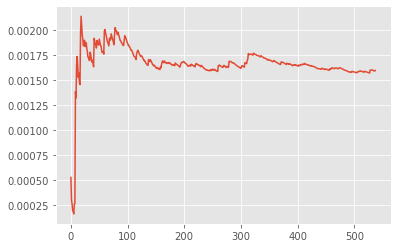

[<tf.Variable 'dense_8/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[-0.11164279],
       [ 0.3324727 ],
       [-0.09651306],
       [ 0.75708437]], dtype=float32)>, <tf.Variable 'dense_8/bias:0' shape=(1,) dtype=float32, numpy=array([0.02240064], dtype=float32)>]
Step 100: loss = 0.0017673169495537877, Time to run 100 steps = 1.101107120513916
Step 200: loss = 0.0016337870620191097, Time to run 100 steps = 1.0297322273254395
Step 300: loss = 0.0015744551783427596, Time to run 100 steps = 1.393146276473999
Step 400: loss = 0.0015028748894110322, Time to run 100 steps = 1.2889769077301025
Step 500: loss = 0.0014712272677570581, Time to run 100 steps = 1.3848340511322021


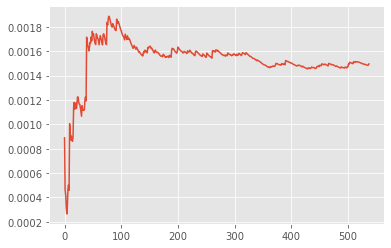

[<tf.Variable 'dense_8/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[-0.12204173],
       [ 0.30630746],
       [-0.11327725],
       [ 0.78470135]], dtype=float32)>, <tf.Variable 'dense_8/bias:0' shape=(1,) dtype=float32, numpy=array([0.02838082], dtype=float32)>]
Step 100: loss = 0.0015040443977341056, Time to run 100 steps = 1.0557680130004883
Step 200: loss = 0.0015380963450297713, Time to run 100 steps = 1.063204288482666
Step 300: loss = 0.001381152542307973, Time to run 100 steps = 1.0227010250091553
Step 400: loss = 0.0014088281895965338, Time to run 100 steps = 1.0262043476104736
Step 500: loss = 0.0014132078504189849, Time to run 100 steps = 1.0327341556549072


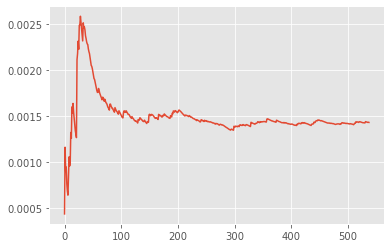

[<tf.Variable 'dense_8/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[-0.12659003],
       [ 0.28729782],
       [-0.12421246],
       [ 0.81535673]], dtype=float32)>, <tf.Variable 'dense_8/bias:0' shape=(1,) dtype=float32, numpy=array([0.03269115], dtype=float32)>]
Step 100: loss = 0.001421410241164267, Time to run 100 steps = 1.0743238925933838
Step 200: loss = 0.001337515190243721, Time to run 100 steps = 1.027134895324707
Step 300: loss = 0.001297185430303216, Time to run 100 steps = 1.0255050659179688
Step 400: loss = 0.001336808199994266, Time to run 100 steps = 1.0773520469665527
Step 500: loss = 0.001362713286653161, Time to run 100 steps = 1.0295069217681885


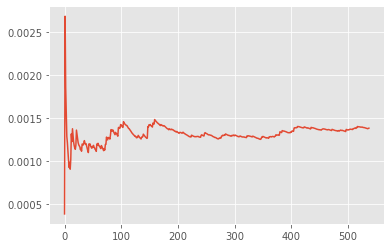

[<tf.Variable 'dense_8/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[-0.13347079],
       [ 0.26495916],
       [-0.1414956 ],
       [ 0.8376414 ]], dtype=float32)>, <tf.Variable 'dense_8/bias:0' shape=(1,) dtype=float32, numpy=array([0.02663705], dtype=float32)>]
Step 100: loss = 0.001579854404553771, Time to run 100 steps = 1.0746748447418213
Step 200: loss = 0.0015202482463791966, Time to run 100 steps = 1.0242021083831787
Step 300: loss = 0.0013845841167494655, Time to run 100 steps = 1.0256521701812744
Step 400: loss = 0.0013663012068718672, Time to run 100 steps = 1.0253520011901855
Step 500: loss = 0.0013082526857033372, Time to run 100 steps = 1.083582878112793


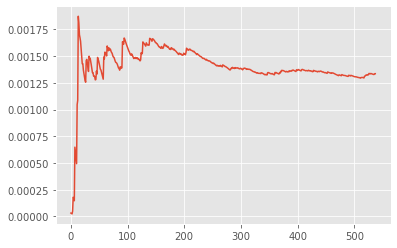

[<tf.Variable 'dense_8/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[-0.13070819],
       [ 0.2522834 ],
       [-0.15094775],
       [ 0.86485606]], dtype=float32)>, <tf.Variable 'dense_8/bias:0' shape=(1,) dtype=float32, numpy=array([0.02975778], dtype=float32)>]


In [28]:
class GlucoseModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.out = tf.keras.layers.Dense(1, input_shape=(4, 1), activation="relu")
        
    def call(self, x):
        x = self.out(x)
        return x


def loss_function(pred_y, y):
  return keras_backend.mean(tf.losses.mean_squared_error(y, pred_y))

def compute_loss(model, x, y, loss_fn=loss_function):
    logits = model(x)
    mse = loss_fn(y, logits)
    return mse, logits

def copy_model(model, x):
    copied_model = GlucoseModel()
    copied_model.call(x)
    copied_model.set_weights(model.get_weights())
    return copied_model


def maml(model, epochs, dataset, lr_inner=0.001, batch_size=1,log_steps=100):
    optimizer = tf.optimizers.Adam()
    
    for _ in range(epochs):
        total_loss = 0
        losses = []
        start = time.time()
        for index, tensor in enumerate(random.sample(dataset.to_numpy().tolist(), len(dataset.to_numpy().tolist()))):
            x = np.reshape(np.array(tensor[:len(tensor)-1]),(1,4))
            y = tensor[-1]
            y_pred = model.call(x)
            with tf.GradientTape() as test_tape:
                with tf.GradientTape() as train_tape:
                    train_loss, _ = compute_loss(model, x, y)
                gradients = train_tape.gradient(train_loss, model.trainable_variables)
                k = 0
                model_copy = copy_model(model, x)
                for j in range(len(model_copy.layers)):
                    model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel,
                                tf.multiply(lr_inner, gradients[k]))
                    model_copy.layers[j].bias = tf.subtract(model.layers[j].bias,
                                tf.multiply(lr_inner, gradients[k+1]))
                    k+=2
                test_loss, logits = compute_loss(model_copy, x, y)
            gradients = test_tape.gradient(test_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            total_loss += test_loss
            loss = total_loss / (index+1.0)
            losses.append(loss)

            if index % log_steps == 0 and index > 0:
                print('Step {}: loss = {}, Time to run {} steps = {}'.format(index, loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.show()
        print(model.weights)
model_one = GlucoseModel()
dataset = trainX_initial.copy()
dataset["Y"] = trainY 
maml(model_one, 5, dataset)

In [29]:
model_one.weights

[<tf.Variable 'dense_8/kernel:0' shape=(4, 1) dtype=float32, numpy=
 array([[-0.13070819],
        [ 0.2522834 ],
        [-0.15094775],
        [ 0.86485606]], dtype=float32)>,
 <tf.Variable 'dense_8/bias:0' shape=(1,) dtype=float32, numpy=array([0.02975778], dtype=float32)>]

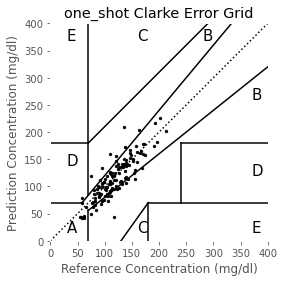

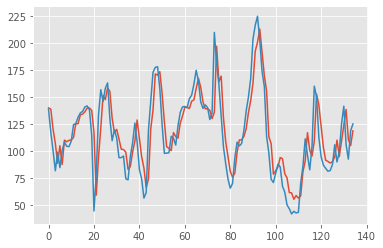

In [30]:
y_pred = inverse_min_max_scaling(model_one.predict(testX_initial), 1.0, 36)
y_truth=inverse_min_max_scaling(testY, 1.0, 36)
plot, zone = clarke_error_grid(y_pred*18, 18*y_truth,"one_shot")
plt.show()
plt.plot(y_pred*18)
plt.plot(np.array(y_truth)*18)
plt.show()

### 3.0 References
1. T. Zhu - Reinforcement learning for blood glucose predictions - https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiquv_N8fDuAhVU9IUKHYcIBMIQFjACegQIAhAC&url=https%3A%2F%2Fwww.mdpi.com%2F1424-8220%2F20%2F18%2F5058%2Fpdf&usg=AOvVaw0LZTeFRkAn-9K3YmGzSpQJ
2. Jason Brownlee - https://machinelearningmastery.com
3. Qingnan Sun, Marko V. Jankovic, Lia Bally, Stavroula G. Mougiakakou - https://arxiv.org/pdf/1809.03817.pdf
4. wikipedia.org
5. SOREN BOUMA - https://sorenbouma.github.io/blog/oneshot/
6. SoftUni presentations and videos - Machine learning, Deep learning
